# ¿How well does a metric learning approach do?

In [1]:
import torch
from functools import partial
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt


# reproducibility
seed = 1993
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = "./data"

## Load and preprocess data

In [2]:
train_dataset_gpu = {}
eval_dataset_gpu = {}

# dataset
train = torchvision.datasets.CIFAR100(root=data_dir, download=True, transform=transforms.ToTensor())
eval = torchvision.datasets.CIFAR100(root=data_dir, train=False, transform=transforms.ToTensor())

# move dataset to gpu
train_dataset_gpu_loader = torch.utils.data.DataLoader(train, batch_size=len(train), drop_last=True,
                                            shuffle=True, num_workers=2, persistent_workers=False)
eval_dataset_gpu_loader = torch.utils.data.DataLoader(eval, batch_size=len(eval), drop_last=True,
                                            shuffle=False, num_workers=1, persistent_workers=False)
train_dataset_gpu['images'], train_dataset_gpu['targets'] = [item.to(device="cuda", non_blocking=True) for item in next(iter(train_dataset_gpu_loader))]
eval_dataset_gpu['images'],  eval_dataset_gpu['targets']  = [item.to(device="cuda", non_blocking=True) for item in next(iter(eval_dataset_gpu_loader)) ]

# normalize images
train_cifar_std, train_cifar_mean = torch.std_mean(train_dataset_gpu['images'], dim=(0, 2, 3)) 
print(f"Mean: {[f'{x:.4f}' for x in train_cifar_mean.tolist()]}")
print(f"Std: {[f'{x:.4f}' for x in train_cifar_std.tolist()]}")
def batch_normalize_images(input_images, mean, std):
    return (input_images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)
batch_normalize_images = partial(batch_normalize_images, mean=train_cifar_mean, std=train_cifar_std)
train_dataset_gpu['images'] = batch_normalize_images(train_dataset_gpu['images'])
eval_dataset_gpu['images']  = batch_normalize_images(eval_dataset_gpu['images'])

data = {
        'train': train_dataset_gpu,
        'eval': eval_dataset_gpu
    }

# pad images for later random cropping
pad_amount = 4
data['train']['images'] = F.pad(data['train']['images'], (pad_amount,)*4, 'reflect')

Files already downloaded and verified
Mean: ['0.5071', '0.4865', '0.4409']
Std: ['0.2673', '0.2564', '0.2762']


### Metric based data loading

In [3]:
from batch_transforms import batch_crop, batch_flip_lr

@torch.no_grad()
def get_batches(data_dict, key, batchsize, paired=True, indices=range(100)):
    # select subset of class indices 
    indices = torch.tensor(indices, device=device)
    images, targets = data_dict[key]["images"], data_dict[key]["targets"] 
    samples = torch.isin(targets, indices)
    images, targets = images[samples], targets[samples]
    
    assert len(images) == len(targets)

    num_epoch_examples = len(images)
    shuffled = torch.randperm(num_epoch_examples, device=device)
    crop_size = 32


    # transforms
    if key == 'train':
        # shuffle the dataset
        images = images[shuffled]
        targets = targets[shuffled]
        images = batch_crop(images, crop_size)
        images = batch_flip_lr(images)

    if paired: 
        # as we are going to pair up the images, we need the size of the dataset to be even
        if len(images) % 2 != 0:
            images = images[:-1]
            targets = targets[:-1]
        # pair up the dataset 
        targets = targets.reshape(num_epoch_examples // 2, 2)
        binary_targets = torch.eq(targets[:,0], targets[:,1])
        # we need that roughly 50% of the pairs are positive and negative
        while binary_targets.float().mean() < 0.5:
            # unpair the target and binary_targets
            targets = targets.reshape(num_epoch_examples)  
            binary_targets = torch.stack([binary_targets, binary_targets], 1).reshape(num_epoch_examples)
            # get negative elements from negative pairs
            neg = binary_targets == False
            # permute them hoping some of them turn into positive pairs
            perm = torch.randperm(len(binary_targets[neg]))
            images[neg] = images[neg][perm]
            targets[neg] = targets[neg][perm]
            # re-pair the targets
            targets = targets.reshape(num_epoch_examples // 2, 2)
            binary_targets = torch.eq(targets[:,0], targets[:,1])
        ## TODO: ensuring 50% distribtution takes much longer than before 
        ## without 50% -> 30 ms
        ## with 50% -> 1 seg
        
        targets = targets.reshape(num_epoch_examples)  
        images = images.reshape(num_epoch_examples // 2, 2, 3, images.shape[-1], images.shape[-2])
        num_epoch_examples = len(images)

    for idx in range(num_epoch_examples // batchsize):
        if paired:
            yield images[idx*batchsize: (idx+1)*batchsize, 0], images[idx*batchsize: (idx+1)*batchsize, 1],  binary_targets[idx*batchsize: (idx+1)*batchsize].int()
        else: 
            yield images[idx*batchsize: (idx+1)*batchsize], targets[idx*batchsize: (idx+1)*batchsize]

#### ¿How do I make sure that the implementation is correct?

- ¿Are there any duplicated or overlapping pairs?
    I think there are not since the pairs are selected by reshaping the original 1d-tensor of targets in a matrix with 2 rows, so if there were not any duplicates in the original tensor, then there must not be any duplicates in the pairs. 

In [4]:
for x, y in get_batches(data, "train", 500, paired=False, indices=1):
    print(x.shape)
    print(y)

torch.Size([500, 3, 32, 32])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 

In [5]:
%%time 

for x1, x2, y in get_batches(data, "train", 128, indices=range(5)):
    pass

CPU times: user 8.91 ms, sys: 3.14 ms, total: 12 ms
Wall time: 10.9 ms


In [6]:
print(x1.shape)
print(x2.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


In [7]:
print(y)

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0', dtype=torch.int32)


In [8]:
idx = 0

0


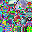

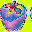

tensor(0, device='cuda:0', dtype=torch.int32)


In [9]:
from torchvision.transforms.functional import to_pil_image
idx_to_class = {i:c for c,i in train.class_to_idx.items()}

print(idx)
display(to_pil_image(x1[idx]))
display(to_pil_image(x2[idx]))

print(y[idx])
# print([idx_to_class[i] for i in y[idx].tolist()])
idx += 1

In [10]:
# %%time 

# for x, y in old_get_batches(data, "train", 128):
#     y

## Implement siamese network

### Model definition

In [11]:
from torch import nn
from torchvision.models import resnet18

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = resnet18()
        self.ndim = self.conv.fc.in_features
        self.conv = nn.Sequential(*list(resnet18().children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(self.ndim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),
        )
     
    def forward_once(self, x):
        x = self.conv(x)         # (bs, ndim, 1, 1)
        x = torch.flatten(x, 1)  # (bs, ndim)
        x = self.fc(x)           # (bs, 2)
        return x 

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)  # (bs, 2)
        output2 = self.forward_once(input2)  # (bs, 2)
        return output1, output2



In [12]:
net = SiameseNetwork()
net.to(device);

### Classification Mechanism

In [13]:
def classify(x, embs):
    input_embs = net.forward_once(x)
    ds = torch.cdist(input_embs, embs, p=2.0) 
    preds = torch.argmin(ds, 1)
    return preds

## Train model

### Loss function

In [14]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = loss.mean()
        return loss

In [15]:
criterion = ContrastiveLoss()

### Train and eval methods

In [16]:
def train(optimizer, task):
    net.train()
    train_loss = 0
    indices = range(increment * task, increment * (task + 1))
    # pbar = tqdm(total=2500, ncols=150)
    for batch_idx, (inputs1, inputs2, targets) in enumerate(get_batches(data, "train", batch_size, indices=indices)):
        optimizer.zero_grad()
        outputs1, outputs2 = net(inputs1, inputs2) # (bs, 2), (bs, 2)
        loss = criterion(outputs1, outputs2, targets) 

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # pbar.update(len(targets))
        # pbar.set_postfix({"loss": train_loss / (batch_idx + 1)})
        

    return train_loss/(batch_idx + 1)

def eval(task):
    net.eval()
    test_loss = 0
    indices = range(increment * task, increment * (task + 1))
    with torch.no_grad():
        for batch_idx, (inputs1, inputs2, targets) in enumerate(get_batches(data, "eval", batch_size, indices=indices)):
            outputs1, outputs2 = net(inputs1, inputs2)
            loss = criterion(outputs1, outputs2, targets)
            test_loss += loss.item()
        return test_loss/(batch_idx + 1)

def mean_embeddings(net, task):
    mean_embs = torch.zeros(increment, 2, device=device)
    for idx in range(task*increment, (task+1)*increment):
        x, _ = next(get_batches(data, "train", 500, paired=False, indices=idx))
        emb = net.forward_once(x) # (500, 2)
        mean_emb = emb.mean(0)
        mean_embs[idx - increment*task] = mean_emb
        
    return mean_embs

### Incremental training

In [17]:
increment = 5
total_classes = 100 
batch_size = 128

# optimizer and scheduler config
init_epochs = 200
init_lr = 0.1
init_weight_decay = 0.0005

rest_epochs = 80
rest_lr = 0.1
rest_weight_decay = 2e-4
rest_milestones = [40, 70]
rest_lr_decay = 0.1

In [18]:
def incremental_train(task):
    tlosses = []
    elosses = []
    # select optimize and scheduler
    if task == 0:
        epochs = init_epochs
        optimizer = optim.Adam(net.parameters(), lr=0.0005)
        # optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=init_lr, weight_decay=init_weight_decay)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    else: 
        epochs = rest_epochs
        optimizer = optim.Adam(net.parameters(), lr=0.0005)
        # optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=rest_lr, weight_decay=rest_weight_decay)
        # scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=rest_milestones, gamma=rest_lr_decay)

    pbar = tqdm(range(epochs), ncols=150, unit="epoch")
    for epoch in pbar:
        tloss = train(optimizer, task)
        eloss = eval(task)
        tlosses.append(tloss)
        elosses.append(eloss)
        # scheduler.step()
        pbar.set_postfix({"Train Loss": tloss, "Eval Acc": eloss})
    embds = mean_embeddings(net, task)

    return tlosses, elosses, embds

#### First task training

In [19]:
tlosses, elosses, embs = incremental_train(task=0)

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02epoch/s, Train Loss=0.247, Eval Acc=0.606]


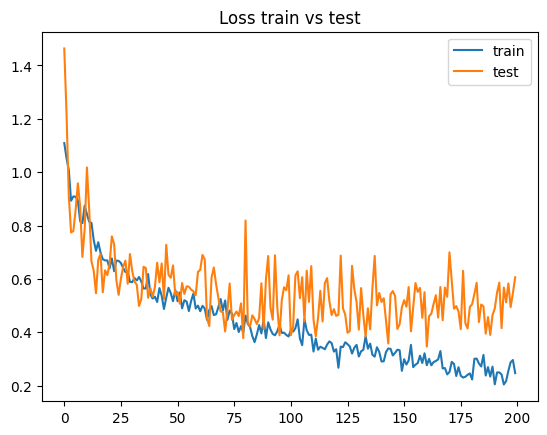

In [20]:
plt.plot(tlosses, label="train")
plt.plot(elosses, label="test")
plt.title("Loss train vs test")
plt.legend()
plt.plot();

In [21]:
embs

tensor([[ 1.5506,  0.0808],
        [-0.1101,  1.3095],
        [ 0.2191, -1.1643],
        [-1.3559, -0.2310],
        [-1.3232,  0.0875]], device='cuda:0', grad_fn=<CopySlices>)

In [22]:
x, y = next(get_batches(data, "eval", batchsize=500,paired=False, indices=range(5)))
print(x.shape)
print(y.shape)
print(y)

torch.Size([500, 3, 32, 32])
torch.Size([500])
tensor([0, 4, 2, 0, 1, 4, 4, 4, 2, 0, 0, 4, 1, 2, 0, 3, 3, 2, 2, 2, 0, 4, 0, 3,
        2, 2, 1, 2, 3, 1, 4, 0, 0, 3, 0, 1, 1, 1, 1, 0, 1, 3, 4, 0, 1, 1, 2, 2,
        3, 2, 2, 0, 1, 0, 3, 2, 3, 1, 4, 1, 1, 0, 2, 2, 3, 3, 3, 0, 0, 4, 1, 0,
        4, 4, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 0, 3, 3, 1, 1, 2, 1, 3, 2, 4, 3, 0,
        4, 2, 2, 1, 3, 4, 0, 3, 2, 4, 3, 2, 4, 0, 4, 3, 0, 3, 1, 2, 1, 0, 3, 0,
        1, 3, 0, 0, 4, 3, 4, 0, 4, 2, 3, 2, 4, 2, 2, 4, 2, 4, 3, 1, 4, 3, 0, 3,
        4, 1, 3, 2, 0, 0, 2, 0, 3, 3, 0, 1, 3, 1, 4, 3, 2, 3, 1, 4, 4, 1, 4, 2,
        3, 0, 1, 3, 2, 1, 0, 1, 0, 3, 0, 4, 2, 2, 2, 2, 3, 3, 0, 1, 4, 0, 1, 0,
        4, 0, 0, 0, 1, 3, 3, 4, 1, 4, 1, 1, 1, 2, 2, 2, 0, 3, 4, 0, 1, 3, 4, 2,
        0, 3, 1, 4, 0, 0, 3, 1, 1, 2, 2, 0, 4, 1, 1, 3, 2, 4, 4, 3, 0, 1, 1, 0,
        0, 3, 1, 4, 0, 1, 4, 4, 3, 2, 4, 0, 4, 0, 4, 4, 1, 2, 3, 3, 0, 3, 0, 3,
        2, 0, 3, 4, 1, 0, 1, 4, 2, 2, 1, 2, 4, 3, 0, 0, 1, 2, 3, 0, 4, 1,

In [23]:
pred = classify(x, embs)
pred

tensor([0, 4, 2, 0, 1, 4, 4, 4, 2, 0, 0, 3, 1, 2, 0, 4, 4, 4, 2, 2, 0, 4, 0, 3,
        1, 2, 2, 2, 3, 1, 4, 0, 0, 3, 2, 1, 1, 1, 1, 1, 1, 4, 4, 0, 1, 1, 2, 0,
        3, 2, 2, 0, 3, 0, 3, 2, 4, 1, 4, 4, 1, 0, 2, 2, 3, 3, 3, 0, 0, 4, 1, 0,
        4, 4, 4, 4, 3, 3, 3, 2, 4, 2, 4, 2, 0, 3, 3, 2, 1, 2, 1, 4, 2, 4, 3, 0,
        4, 2, 2, 1, 3, 4, 0, 3, 2, 4, 4, 2, 4, 0, 3, 3, 0, 3, 4, 2, 1, 0, 4, 0,
        1, 3, 0, 0, 3, 4, 2, 0, 2, 2, 2, 4, 4, 2, 2, 4, 2, 1, 4, 1, 4, 3, 0, 3,
        4, 1, 4, 2, 0, 0, 2, 0, 3, 4, 0, 2, 4, 1, 3, 4, 2, 3, 1, 4, 3, 1, 4, 2,
        3, 0, 1, 3, 2, 1, 0, 1, 0, 3, 0, 4, 2, 2, 3, 0, 4, 4, 0, 1, 3, 0, 1, 0,
        3, 0, 0, 0, 1, 3, 4, 4, 4, 4, 1, 1, 1, 2, 2, 2, 0, 3, 4, 0, 1, 4, 4, 2,
        0, 3, 1, 3, 0, 2, 4, 1, 1, 2, 2, 0, 3, 1, 1, 4, 2, 4, 4, 3, 0, 1, 1, 3,
        2, 3, 1, 4, 0, 1, 4, 4, 4, 0, 4, 0, 4, 0, 4, 3, 1, 2, 3, 4, 0, 3, 0, 3,
        2, 0, 3, 4, 1, 0, 1, 3, 2, 2, 1, 2, 4, 3, 0, 0, 1, 2, 4, 0, 4, 1, 4, 1,
        2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 4,

In [24]:
def accuracy(pred, y):
    assert pred.shape == y.shape
    correct = (pred == y).sum()
    total = len(pred)
    return correct / total 

In [25]:
acc_task1 = accuracy(pred, y)
acc_task1

tensor(0.7880, device='cuda:0')

#### Second task Training

In [26]:
tlosses_task2, elosses_task2, embs_task2 = incremental_train(task=1)

100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:38<00:00,  2.05epoch/s, Train Loss=0.432, Eval Acc=0.476]


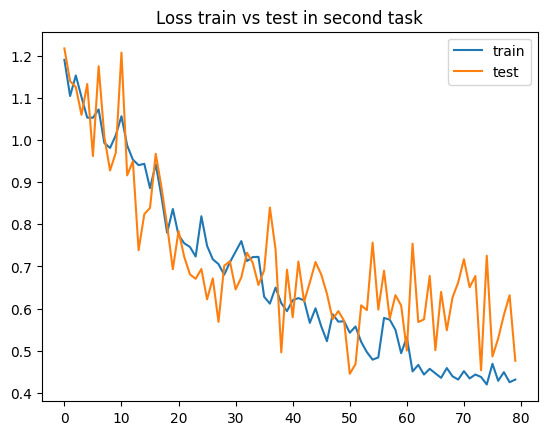

In [27]:
plt.plot(tlosses_task2, label="train")
plt.plot(elosses_task2, label="test")
plt.title("Loss train vs test in second task")
plt.legend()
plt.plot();

In [29]:
print(embs_task2)

tensor([[ 0.8902, -0.4861],
        [-0.1426,  0.3958],
        [-0.4983,  0.2453],
        [-1.2503, -0.9789],
        [ 0.1272, -1.3246]], device='cuda:0', grad_fn=<CopySlices>)


In [35]:
embs = torch.cat([embs, embs_task2], 0)

In [36]:
x, y = next(get_batches(data, "eval", batchsize=500,paired=False, indices=range(10)))
print(x.shape)
print(y.shape)
print(y)

torch.Size([500, 3, 32, 32])
torch.Size([500])
tensor([0, 8, 8, 4, 6, 9, 2, 7, 6, 0, 9, 8, 1, 4, 4, 8, 9, 4, 7, 6, 6, 2, 0, 0,
        4, 6, 1, 6, 7, 8, 2, 7, 5, 9, 7, 7, 0, 6, 3, 6, 3, 2, 8, 2, 5, 9, 7, 5,
        2, 6, 0, 8, 4, 0, 3, 2, 8, 6, 2, 8, 1, 2, 9, 7, 9, 3, 1, 4, 0, 0, 3, 8,
        7, 0, 5, 1, 6, 1, 1, 7, 1, 0, 1, 3, 4, 8, 7, 7, 0, 1, 6, 6, 7, 6, 9, 1,
        2, 8, 2, 9, 6, 3, 2, 9, 2, 0, 9, 1, 0, 3, 8, 6, 9, 2, 3, 7, 7, 1, 8, 4,
        1, 1, 9, 9, 0, 5, 2, 2, 3, 5, 5, 7, 6, 5, 5, 3, 3, 0, 0, 4, 5, 9, 6, 1,
        5, 5, 6, 0, 4, 8, 5, 8, 5, 8, 9, 9, 4, 8, 3, 2, 7, 9, 3, 7, 9, 3, 6, 9,
        3, 5, 3, 7, 2, 2, 3, 8, 7, 5, 7, 2, 5, 0, 3, 3, 1, 8, 1, 2, 6, 1, 5, 3,
        2, 7, 7, 6, 9, 4, 3, 0, 9, 4, 6, 2, 2, 7, 8, 9, 1, 3, 5, 4, 5, 5, 0, 6,
        7, 3, 8, 2, 4, 3, 6, 2, 7, 4, 6, 0, 5, 7, 4, 3, 0, 3, 1, 9, 2, 1, 5, 6,
        0, 5, 5, 5, 3, 5, 0, 9, 1, 6, 3, 8, 0, 8, 9, 0, 6, 8, 9, 5, 4, 5, 3, 5,
        4, 6, 0, 4, 2, 3, 2, 4, 7, 2, 6, 5, 5, 2, 7, 6, 5, 4, 2, 4, 3, 9,

In [37]:
pred = classify(x, embs)
pred

tensor([6, 8, 8, 2, 6, 9, 5, 6, 6, 6, 9, 8, 2, 7, 8, 8, 9, 8, 7, 6, 6, 2, 5, 6,
        8, 5, 6, 6, 6, 8, 2, 8, 5, 9, 7, 7, 2, 6, 6, 6, 7, 8, 8, 2, 5, 9, 7, 5,
        9, 6, 7, 2, 5, 5, 9, 2, 8, 3, 5, 8, 8, 5, 9, 6, 6, 6, 6, 6, 5, 2, 8, 8,
        7, 2, 5, 8, 9, 2, 5, 7, 2, 2, 9, 7, 6, 9, 7, 7, 6, 5, 6, 6, 7, 6, 9, 6,
        7, 8, 5, 9, 6, 8, 6, 9, 5, 6, 9, 2, 5, 7, 8, 6, 9, 2, 7, 7, 6, 6, 3, 8,
        8, 5, 9, 9, 5, 5, 2, 5, 7, 5, 5, 7, 6, 2, 5, 8, 7, 7, 7, 7, 8, 9, 6, 6,
        5, 5, 6, 2, 3, 2, 5, 8, 5, 8, 9, 9, 8, 8, 6, 2, 7, 9, 3, 6, 9, 5, 7, 9,
        7, 5, 7, 2, 6, 5, 7, 8, 7, 6, 7, 5, 5, 5, 7, 8, 5, 3, 5, 5, 6, 2, 5, 7,
        5, 7, 7, 6, 7, 6, 7, 5, 9, 5, 6, 9, 2, 3, 8, 9, 6, 7, 5, 7, 5, 5, 2, 6,
        8, 5, 8, 8, 2, 3, 6, 6, 7, 2, 6, 6, 9, 7, 8, 7, 2, 7, 6, 9, 6, 5, 5, 6,
        5, 5, 5, 5, 7, 2, 7, 2, 5, 6, 6, 8, 2, 8, 9, 5, 6, 8, 9, 8, 7, 5, 5, 5,
        5, 6, 5, 6, 7, 2, 5, 6, 6, 2, 6, 5, 5, 9, 6, 7, 5, 8, 8, 8, 6, 9, 5, 2,
        5, 6, 7, 6, 8, 6, 3, 6, 8, 5, 7,

In [39]:
acc_task2 = accuracy(pred, y)
acc_task2

tensor(0.4260, device='cuda:0')

## Review results

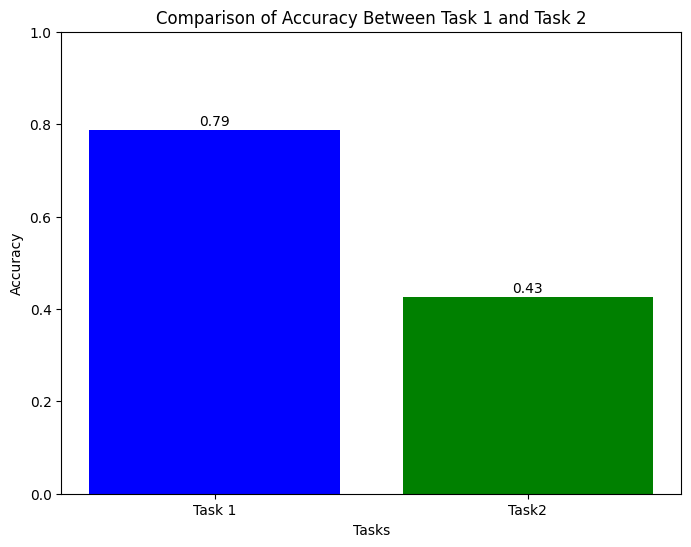

In [41]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
methods = ['Task 1', 'Task2']
accuracies = [acc_task1.item(), acc_task2.item()]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(methods, accuracies, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Tasks')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between Task 1 and Task 2')

# Add data values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center')

# Show the plot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.show()
